### Experiment Setup
The list of factors contains the names of the input parameters of the model. The replications is the number of runs per experiment. The ExcelFormat variable toggles the output of the experiments table to either ascii or tab separated values which can be copied and pasted in Excel. After running the cells below the experiment design matrix will be produced including the randomized order for performing them. 

In [276]:
#-- Make sure you have these packages installed
#--
#pip install numpy scipy matplotlib plotly
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, scipy as sp, plotly.graph_objects as go

In [277]:
#-- Select Example 
#--
Example = 1 #-- Brush width: only one factor is significant
Example = 2 #-- Brush length: dodgy data and model R^2 is low
Example = 3 #-- Extrude width: all factors are significant
# Example = 4 #-- 3-Factor model with interesting interactions

#-- 2-Factor Example
#--
if( Example in [1, 2, 3] ):
    FactorNames = [
        'Speed',
        'Offset']         #-- Edit this
    Replications = 3      #-- Edit this

#-- 3-Factor Example
#--
if( Example == 4 ):
    FactorNames = [
        'Speed',
        'Depth',
        'Angle']          #-- Edit this
    Replications = 2      #-- Edit this

#-- Print Model Info
#--
Factors      = len( FactorNames )
Combinations = 2 ** Factors
print( f'Factors: {Factors}' )
print( f'Replications: {Replications}' )
print( f'Combinations: {Combinations}' )
print( f'Experiments: {Combinations * Replications}' )

Factors: 2
Replications: 3
Combinations: 4
Experiments: 12


### Build the Experiments Table

In [278]:
np.random.seed( 17 )
Order = np.arange( 0, Combinations )
np.random.shuffle( Order )

print( 'Design Table' )
padding = 6
maximum = 2 + len( max( FactorNames, key = len ) )
column  = lambda value : str( value ).center( maximum )

header = column( "Index" ) + column( "Order" )
for factor in FactorNames:
    header += column( factor )

for replication in range( 0, Replications ):
    header += column( f"Repl{1 + replication}" )

print( header )

for i in range( Combinations ):
    row = column( i ) + column( Order[i] )

    for j in range( 0, int( Factors ) ):
      row += column( "+" if ( i >> j ) & 1 else "-" )

    for replication in range( 0, Replications ):
        row += column( "0.0" )

    print( row )

Design Table
 Index   Order   Speed   Offset  Repl1   Repl2   Repl3  
   0       0       -       -      0.0     0.0     0.0   
   1       2       +       -      0.0     0.0     0.0   
   2       1       -       +      0.0     0.0     0.0   
   3       3       +       +      0.0     0.0     0.0   


### Data Tabulation
After performing the experiments, in the random order produced in the relevant column, write down the values in the replications columns. The script will parse the values into a numpy array. Verify that no errors are present before continuing. 

In [279]:
#-- Update the data below with your measurements
#--
if( Example == 1 ):
  data = """
Index   Order   Speed   Offset  Repl1   Repl2   Repl3  
  0       3      5.0     1.0    1.253   1.550   0.900   
  1       2      50.0    1.0    1.053   1.458   0.944  
  2       0      5.0     5.0    3.669   3.504   3.164   
  3       1      50.0    5.0    2.601   3.660   2.640  
  """ 

if( Example == 2 ):
  data = """
Index   Order   Speed   Offset  Repl1   Repl2   Repl3  
  0       3      5.0     1.0   193.368  193.861  195.791 
  1       2      50.0    1.0   194.354  195.341  195.834
  2       0      5.0     5.0   170.180  138.235  119.488   
  3       1      50.0    5.0   191.394  157.599  118.187
  """ 

if( Example == 3 ):
  data = """
Index   Order   Speed   Offset   Repl1   Repl2   Repl3    
  0       0      0.2     2.0     5.491   4.943   5.198   
  1       2      0.2     6.0     3.478   3.504   4.036   
  2       1      1.0     2.0     2.140   2.020   2.693  
  3       3      1.0     6.0     1.600   1.365   1.545   
  """

if( Example == 4 ):
  data = """
  Index  Order  Speed  Depth  Angle  Repl1  Repl2
    0      7      -      -      -     9.0    7.0
    1      0      +      -      -    10.0   12.0
    2      3      -      +      -     9.0   11.0
    3      1      +      +      -    12.0   10.0
    4      2      -      -      +    11.0   10.0
    5      5      +      -      +    10.0   13.0
    6      4      -      +      +    10.0    9.0
    7      6      +      +      +    16.0   14.0
  """
data = np.array( [row.strip( ).split( )[2+Factors:]
    for row in data.strip( ).split( '\n' )[1:]] ).astype( float )
print( data )

[[5.491 4.943 5.198]
 [3.478 3.504 4.036]
 [2.14  2.02  2.693]
 [1.6   1.365 1.545]]


### Measurement Normality
The data should normally distributed for this to make any sense. We can use a Q-Q plot to visualize that relationship and access some metrics below. Theoretically, if the samples are from a normal distribution the Q-Q plot should fit the line x = y, that is alpha=1.0 and beta=0.0. Additionally, the Shapiro-Wilk test can be performed, where we expect p-value > 0.05.

Measured Data: Mean=3.168, StdDev=1.431, N=12
Linear Regression: Alpha=1.016, Beta=-0.000, R^2=0.963, p-Value=0.000 StdErr=0.090
Shapiro-Wilk Test: Statistic=0.910, p-Value=0.211


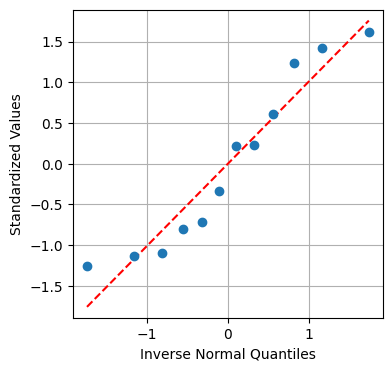

In [280]:
def NormalityTest( data, filename = '' ):
    ys = np.sort( data.flatten( ) ) #-- Sort the data
    m, s, n = np.mean( ys ), np.std( ys ), len( ys )
    print( f'Measured Data: Mean={m:.3f}, StdDev={s:.3f}, N={n}' )
    ys = ( ys - m ) / s #-- Standardize the data
    xs = sp.stats.norm.ppf( ( np.arange( 1, n + 1 ) - 0.5 ) / n )

    a, b, r, p, e = sp.stats.linregress( xs, ys ) #-- Linear regression
    Ys = a * xs + b; R = ys - Ys
    print( f'Linear Regression: Alpha={a:.3f}, Beta={b:.3f}, R^2={r:.3f}, p-Value={p:.3f} StdErr={e:.3f}' )

    statistic, p_value = sp.stats.shapiro( ys ) #-- Normality Testing
    print( f'Shapiro-Wilk Test: Statistic={statistic:.3f}, p-Value={p_value:.3f}' )

    fig, ax = plt.subplots( figsize=( 4, 4 ) )
    ax.scatter( xs, ys, zorder=4 )
    ax.plot( xs, Ys, color='red', ls='--', zorder=2)
    ax.set_xlabel( 'Inverse Normal Quantiles'  )
    ax.set_ylabel( 'Standardized Values' )
    ax.grid( True )
    ax.axis( 'equal' )
    ax.set_axisbelow( True )
    if( filename != '' ): plt.savefig( filename )
    plt.show( )
NormalityTest( data, 'qqf.svg' )

### Modeling Sections
This section produces the design matrix and model fitting step by step for illustration purposes. You can skip to the model construction and validation sections.

In [281]:
print( "Degrees of Freedom" )
dof_model = 2 ** Factors - 1
dof_total = ( 2 ** Factors ) * Replications - 1
dof_error = dof_total - dof_model
print( f"  Model {dof_model}" )
print( f"  Error {dof_error}" )
print( f"  Total {dof_total}" )

print( 'Design Matrix' )
design = np.array( [[( ( i >> j ) & 1 ) * 2 - 1
    for j in range( Factors )] for i in range( 2 ** Factors )] )
print( design )

Degrees of Freedom
  Model 3
  Error 8
  Total 11
Design Matrix
[[-1 -1]
 [ 1 -1]
 [-1  1]
 [ 1  1]]


In [282]:
print( 'All Factor Combinations' )
from itertools import combinations
combs = [[[*c] for c in combinations( range( Factors ), r )]
    for r in range( 1, Factors + 1 )]
print( combs )

print( f'Full Factorial Matrix' )
matrix = np.array( [np.prod( design[:,cols], axis=1 )
    for group in combs for cols in group] ).T
print( matrix )

print( 'Factor Labels' )
factor_names = np.array( [''.join( [chr( ord( 'a' ) + i ) for i in combo] )
    for group in combs for combo in group] )
print( factor_names )

All Factor Combinations
[[[0], [1]], [[0, 1]]]
Full Factorial Matrix
[[-1 -1  1]
 [ 1 -1 -1]
 [-1  1 -1]
 [ 1  1  1]]
Factor Labels
['a' 'b' 'ab']


In [ ]:
print( 'Totals' )
totals = np.sum( data, axis = 1 )
print( totals )

print( 'Contrasts' )
contrasts = totals @ matrix
print( contrasts  )

print( 'Effects' )
effects = contrasts / ( ( 2 ** ( Factors - 1 ) ) * Replications )
print( effects )

print( 'Sum of Squares' )
sum_of_squares = contrasts * contrasts / ( ( 2 ** Factors ) * Replications )
print( sum_of_squares )

#-- Errors
#--
mean_value = np.mean( data )
ss_model = np.sum( sum_of_squares )
ss_total = np.sum( ( data - mean_value ) ** 2 )
ss_error = ss_total - ss_model
ms_error = ss_error / dof_error
st_error = np.sqrt( 0.5 * ms_error / Replications )
print( 'Errors' )
print( f'  SS Model: {ss_model:>8.3f}' )
print( f'  SS Error: {ss_error:>8.3f}' )
print( f'  SS Total: {ss_total:>8.3f}' )
print( f'  MS Error: {ms_error:>8.3f}' )
print( f'  St Error: {st_error:>8.3f}' )

print( f'R^2 reg: {100 * ss_model / ss_total:>4.1f}%' )
print( f'R^2 adj: {100 - 100 * ( ss_error / dof_error ) / ( ss_total / dof_total ):>4.1f}%' )

print( 'F-Statistic' )
f_statistics = sum_of_squares / ms_error
print( f_statistics )

print( 't-Statistic' )
t_statistics =  effects / st_error
print( t_statistics )

Totals
[15.632 11.018  6.853  4.51 ]
Contrasts
[ -6.957 -15.287   2.271]
Effects
[-1.1595     -2.54783333  0.3785    ]
Sum of Squares
[ 4.03332075 19.47436408  0.42978675]
Errors
  SS Model:   23.937
  SS Error:    0.637
  SS Total:   24.574
  MS Error:    0.080
  St Error:    0.115
R^2 reg: 97.4%
R^2 adj: 96.4%
F-Statistic
[ 50.67967414 244.70020785   5.40037696]
t-Statistic
[-10.06773799 -22.12239625   3.28645005]


In [284]:
print( 'p-Values' )
p_values = np.array( [2 * ( 1.0 - sp.stats.t.cdf( abs( t ), dof_error ) ) for t in t_statistics] )
for label, value in zip( factor_names, p_values ):
    print( f'  {label:>3} : {value:.5f}' )

p-Values
    a : 0.00001
    b : 0.00000
   ab : 0.01108


### Model Construction
After performing the analysis of variation above we can determine the significance of certain factors and combinations thereof. If desired then we can either build a complete model where all factors and their combinations are used or produce a reduced model where only significant coefficients are used. Toggle the variable `reduced` and observe the results of the model validations steps.

In [300]:
#-- Linear Model
#--
model_coefficients = effects * 0.5

significant = p_values < 0.05
print( f'Significance: {significant}')

reduced = False
if( reduced ):
    model_coefficients = model_coefficients * significant

print( 'Linear Model' )
print( f'y = {mean_value:8.4f}\n  ' + '\n  '.join(
    [f'{"-" if c < 0 else "+"} {abs( c ):8.4f} * {f}'
     for c, f in zip( model_coefficients, factor_names )] ) )

Significance: [ True  True  True]
Linear Model
y =   3.1678
  -   0.5797 * a
  -   1.2739 * b
  +   0.1892 * ab


### Model Validation

In [286]:
print( 'Measured Predicted Residual Experiment' )
residuals = []
predicted = []
for c, r in zip(matrix, data):
  Y = mean_value + np.dot( c, model_coefficients )
  for y in r:
    residuals.append( y - Y )
    predicted.append( Y )
    print(f'{y:8.3f} {Y:8.3f} {y - Y:8.3f} ' + ''.join(
      [f'  {v:+d}' for v in c[0:3]]))
residuals = np.array( residuals )
predicted = np.array( predicted )

Measured Predicted Residual Experiment
   5.491    5.211    0.280   -1  -1  +1
   4.943    5.211   -0.268   -1  -1  +1
   5.198    5.211   -0.013   -1  -1  +1
   3.478    3.673   -0.195   +1  -1  -1
   3.504    3.673   -0.169   +1  -1  -1
   4.036    3.673    0.363   +1  -1  -1
   2.140    2.284   -0.144   -1  +1  -1
   2.020    2.284   -0.264   -1  +1  -1
   2.693    2.284    0.409   -1  +1  -1
   1.600    1.503    0.097   +1  +1  +1
   1.365    1.503   -0.138   +1  +1  +1
   1.545    1.503    0.042   +1  +1  +1


Measured Data: Mean=-0.000, StdDev=0.230, N=12
Linear Regression: Alpha=1.005, Beta=-0.000, R^2=0.953, p-Value=0.000 StdErr=0.101
Shapiro-Wilk Test: Statistic=0.892, p-Value=0.125


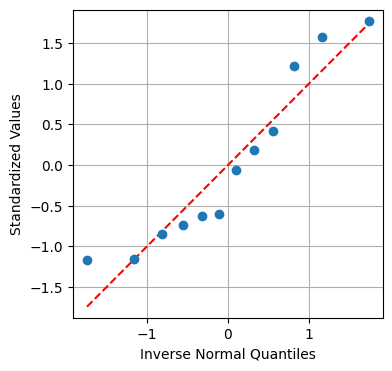

In [287]:
NormalityTest( residuals, 'qqr.svg' )

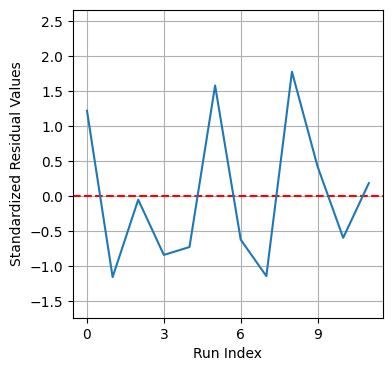

In [288]:
def ResidualRunPlot( data, filename = '' ):
    ys = data.flatten( )
    m, s, n = np.mean( ys ), np.std( ys ), len( ys )
    ys = ( ys - m ) / s #-- Standardize the data
    xs = np.arange( n )
    fig, ax = plt.subplots( figsize=( 4, 4 ) )
    ax.plot( xs, ys, zorder=4 )
    ax.set_xlabel( 'Run Index'  )
    ax.set_ylabel( 'Standardized Residual Values' )
    ax.grid( True )
    ax.set_xticks( xs[::3], [str( int( x ) ) for x in xs[::3]] )
    ax.set_ylim( np.min( ys ) * 1.5, np.max( ys ) * 1.5 )
    ax.axhline( 0.0, color='red', ls='--', zorder=2)
    ax.set_axisbelow( True )
    if( filename != '' ): plt.savefig( filename )
    plt.show( )
ResidualRunPlot( residuals, 'srr.svg' )

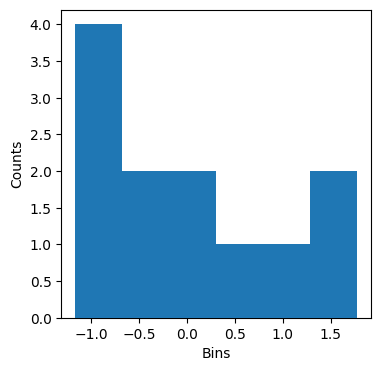

In [289]:
def ResidualsHistogram( data, filename = '' ):
    ys = data.flatten( )
    m, s, n = np.mean( ys ), np.std( ys ), len( ys )
    ys = ( ys - m ) / s #-- Standardize the data
    fig, ax = plt.subplots( figsize=( 4, 4 ) )
    ax.set_xlabel( 'Bins'  )
    ax.set_ylabel( 'Counts' )
    ax.hist( ys, bins=6, zorder=4 )
    if( filename != '' ): plt.savefig( filename )
ResidualsHistogram( residuals, 'rhp.svg' )

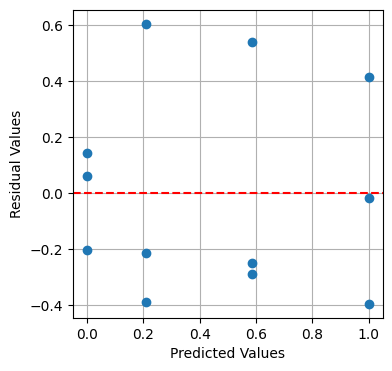

In [290]:
def ResidualsPredictedPlot( predicted, residuals, filename = '' ):
    pmm = ( np.min( predicted ), np.max( predicted ) )
    rmm = ( np.min( residuals ), np.max( residuals ) )

    xs = ( predicted - pmm[0] ) / ( pmm[1] - pmm[0] )
    ys = ( residuals          ) / ( rmm[1] - rmm[0] )

    fig, ax = plt.subplots( figsize=( 4, 4 ) )
    ax.scatter( xs, ys )
    ax.set_xlabel( 'Predicted Values' )
    ax.set_ylabel( 'Residual Values' )
    ax.grid( True )
    ax.axhline( 0.0, color='red', ls='--', zorder=2)
    ax.set_axisbelow( True )
    if( filename != '' ): plt.savefig( filename )
    plt.show( )
ResidualsPredictedPlot( predicted, residuals, 'rpp.svg' )

### Model Packaging

In [ ]:

model_terms = [factors for order in combs for factors in order]
model = lambda values: mean_value + sum( coefficient * np.prod( [values[index] for index in term] )
    for coefficient, term in zip( model_coefficients, model_terms ) )

print( model( [ 1, 1, 1] ) )
print( model( [-1,-1,-1] ) )


1.5033333333333339
5.210666666666667


In [323]:
#-- Using Minimum and Maximum Values
#--
def BeadWidthCoded( speed, offset ):
    return ( 3.1678 - 
             0.5797 * speed  -   
             1.2739 * offset + 
             0.1892 * speed * offset )

def Normalize( value, vmin, vmax ):
    normalized = ( value - vmin ) / ( vmax - vmin )
    return normalized * 2 - 1

def BeadWidthActual( speed, offset ):
    return BeadWidthCoded(
        Normalize( speed,  1.0, 6.0 ), 
        Normalize( offset, 0.2, 2.0 ) )

print( BeadWidthCoded ( -1.0, -1.0 ) )
print( BeadWidthActual(  1.0,  0.2 ) )

5.2105999999999995
5.2105999999999995


### Model Visualizations

In [292]:
def Plot3fModel( ):
    fig, axs = plt.subplots( 3, 3,
        figsize=( 8, 8 ), subplot_kw={'projection': '3d'} )

    indices = [[0, 1, 2], [1, 2, 0], [2, 0, 1]]
    def select( xyv, ijk ):
        return [xyv[ijk[0]], xyv[ijk[1]], xyv[ijk[2]]]

    for row, ids in enumerate( indices ):
        for col, z in enumerate( [-1, 0, 1] ):
            ax = axs[row, col]

            ax.set_xlabel( FactorNames[ids[0]] )
            ax.set_ylabel( FactorNames[ids[1]] )

            X, Y = np.meshgrid(
                np.linspace( -1, 1, 10 ),
                np.linspace( -1, 1, 10 ) )
            Z = np.array( [[model( select( [x, y, z], ids ) )
                    for x, y in zip( xs, ys )]
                        for xs, ys in zip( X, Y )] )
            ax.plot_surface( X, Y, Z, cmap='viridis', alpha=0.75 )
            ax.text( 0, 0, np.mean( Z ),
                f'{FactorNames[ids[2]]}={z}',
                fontsize=10, ha='center', va='center' )
    plt.show( )
if( Factors == 3 ): Plot3fModel( )


In [324]:
def Plot2fModel( ):
    X, Y = np.meshgrid(
        np.linspace( -1, 1, 10 ), 
        np.linspace( -1, 1, 10 ) )
    Z = np.array( [[model( [x, y] )
            for x, y in zip( xs, ys )]
                for xs, ys in zip( X, Y )] )

    import plotly.express as px
    plots = [go.Surface( x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.75, showscale=False )]
    for index, ( x, y ) in enumerate( [(-1,-1), (-1,1), (0,0), (1,-1), (1,1)] ):
        plots.append( go.Scatter3d( x=[x], y=[y], z=[model( [x, y] )], 
            mode='markers', marker=dict(size=8, color=px.colors.qualitative.Plotly[index]),name=f'{model( [x, y] ):.2f}' ) )

    fig = go.Figure(data=plots)

    fig.update_layout(
        margin=dict(l=10, r=10, b=10, t=10),
        width=450,
        height=400,
        scene=dict(
            xaxis_title=FactorNames[0],
            yaxis_title=FactorNames[1],
            zaxis_title='Model Value',
            xaxis=dict(showspikes=False),
            yaxis=dict(showspikes=False),
            zaxis=dict(showspikes=False)
        ),
        # legend=dict(
        #     orientation="h",
        #     x=0.5,
        #     y=-0.2,
        #     xanchor="center",
        #     yanchor="top" 
        # ) ,
        scene_camera=dict(
            eye=dict(x=-2.5, y=-2.5, z=2), 
            projection=dict(type="orthographic")
        ),
    )
    #print( fig.to_html(full_html=False, include_plotlyjs='cdn'))
    fig.show( )
if( Factors == 2 ):Plot2fModel( )

In [294]:
from ipywidgets import interactive_output, FloatSlider, VBox, Output
from IPython.display import display

sliders = [
    FloatSlider(
        value = p,
        min = -1,
        max = 1,
        step = 0.1,
        description = FactorNames[i],
        continuous_update = True )
    for i, p in enumerate( [0] * Factors )
]

out = Output( )

def update( change = None ):
    result = model( [slider.value for slider in sliders] )
    with out:
        out.clear_output( wait=True )
        print( f"Result: {result:.3f}" )

for slider in sliders:
    slider.observe( update, names='value' )

display( VBox( sliders ), out )

update( )

Output()

### Optimization

In [295]:
import numpy as np
from scipy.optimize import minimize

xo = np.zeros( Factors )

result = minimize( model, xo, bounds=[(-1, 1)] * Factors, method='L-BFGS-B' )

print( f'Factors: {result.x} -> Minimum: {result.fun:.3f}' )
print( result )

Factors: [1. 1.] -> Minimum: 1.503
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.5033333333333339
        x: [ 1.000e+00  1.000e+00]
      nit: 2
      jac: [-3.905e-01 -1.085e+00]
     nfev: 9
     njev: 3
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [ ]:
def TargetValue( x ):
    return ( model( x ) - 2.0 ) ** 2

xo = np.zeros( Factors )

result = minimize( TargetValue, xo, bounds=[(-1, 1)] * Factors, method='L-BFGS-B' )

print( f'Factors: {result.x} -> Error: {result.fun:.3f}' )
print( result )

Factors: [0.70204336 0.66670002] -> Error: 0.000
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.0144130705977331e-12
        x: [ 7.020e-01  6.667e-01]
      nit: 5
      jac: [ 9.157e-07  2.312e-06]
     nfev: 18
     njev: 6
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
